##### Copyright 2022 The Cirq Developers

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# QVM Stabilizer Example

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/simulate/qvm_stabilizer_example"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/simulate/qvm_stabilizer_example.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/simulate/qvm_stabilizer_example.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/simulate/qvm_stabilizer_example.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

This notebook demonstrates how to use a [Quantum Virtual Machine](/cirq/simulate/quantum_virtual_machine) with larger, more elaborate circuits to demonstrate [stabilizer](https://en.wikipedia.org/wiki/Stabilizer_code){:.external} circuits and how they can reveal hardware errors.

## **Install** Cirq and qsim, Create **Quantum Virtual Machine**

In [ ]:
# @title Install `cirq_google` and `qsimcirq`

try:
    import cirq
    import cirq_google
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq-google
    print("installed cirq.")
    import cirq
    import cirq_google

try:
    import qsimcirq
except ImportError:
    print("installing qsimcirq...")
    !pip install --quiet qsimcirq
    print(f"installed qsimcirq.")
    import qsimcirq

# Other modules used in this colab
import matplotlib.pyplot as plt
import time
import random

In [ ]:
# @title Create Quantum Virtual Machine: Choose a processor ("rainbow" or "weber")
processor_id = "rainbow"  # @param {type:"string"}

# Instantiate the engine.
sim_engine = cirq_google.engine.create_default_noisy_quantum_virtual_machine(
    processor_id=processor_id, simulator_class=qsimcirq.QSimSimulator
)
print(
    "Your quantum virtual machine",
    processor_id,
    "is ready, here is the qubit grid:",
    "\n========================\n",
)
print(sim_engine.get_processor(processor_id).get_device())

## **Introduction** to stabilizer measurements

The following code blocks measure a Z stabilizer as described by [Fowler et al (2012)](https://arxiv.org/abs/1208.0928). This type of circuit is central to the field of quantum error correction via the idea of a [Stabilizer Code](https://en.wikipedia.org/wiki/Stabilizer_code){:.external}. 

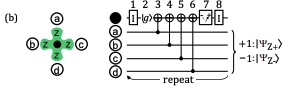

This circuit is constructed such that the central "measure" qubit will be in the $|1\rangle$ state if an odd number of the four surrounding "data" qubits (named a-d in the figure) have a bit-flip error (corresponding to an X gate).

## Stabilizer measurements on a **small grid**

The examples below demonstrate a single Z stabilizer, similar to the image above. 

### Without noise

In a perfectly noiseless Z stabilizer, all qubits will remain in the $|0\rangle$ state.

In [ ]:
data_qubits = [cirq.NamedQubit('data_' + str(x)) for x in 'abcd']
measure_qubit = cirq.NamedQubit('_meas')
stabilizer_circuit = cirq.Circuit(
    *[cirq.CX(data_qubit, measure_qubit) for data_qubit in data_qubits],
    cirq.measure(measure_qubit, key='meas'),
)

print(f'Z-stabilizer circuit:')
print('========================')
print(stabilizer_circuit)

In [ ]:
simulator = cirq.Simulator()
result = simulator.run(stabilizer_circuit, repetitions=100)
ax = cirq.plot_state_histogram(result)
plt.show(ax)

### With fixed noise

If one of the qubits is flipped, the measure qubit will also flip to match the parity of the data qubits.

In [ ]:
random_data_qubit = random.choice(data_qubits)
stabilizer_circuit_with_error = cirq.X(random_data_qubit) + stabilizer_circuit

print(f'Z-stabilizer circuit with single error:')
print('========================')
print(stabilizer_circuit_with_error)

In [ ]:
result = simulator.run(stabilizer_circuit_with_error, repetitions=100)
ax = cirq.plot_state_histogram(result)
plt.show(ax)

### With hardware noise on the QVM

With hardware-like noise, the stabilizer circuit becomes much more interesting. An arbitrary error could occur at any point:

*   On a data qubit before or after the CNOT
*   On the measure qubit before or after the CNOTs
*   On the measure qubit _between_ CNOTs
*   Multiple errors in any combination of the above locations

The only indication of that error comes from the output of the measure qubit. By creating a grid of stabilizers and observing how they change over time, it's possible to decode when and where errors occured and compensate for them.

The example below only runs a single cycle of one Z stabilizer, so it can't pinpoint error precisely. However, by measuring the data qubits afterwards it's possible to guess at where the error(s) took place.

In [ ]:
# Add measurements to the data qubits.
stabilizer_circuit_for_hardware = stabilizer_circuit + (
    cirq.Moment(cirq.measure(data_qubit, key=str(data_qubit)[-1]) for data_qubit in data_qubits)
)
print(f'Z-stabilizer circuit with data measurement:')
print('========================')
print(stabilizer_circuit_for_hardware)

In [ ]:
# Device_stabilizer_plaquette is an X-shaped region of qubits
# on the actual device.
device_stabilizer_plaquette = [
    cirq.GridQubit(5, 3),
    cirq.GridQubit(5, 2),
    cirq.GridQubit(4, 3),
    cirq.GridQubit(5, 4),
    cirq.GridQubit(6, 3),
]

# Translate the circuit to a suitable gate set.
test_stabilizer_circuit = cirq.optimize_for_target_gateset(
    stabilizer_circuit_for_hardware,
    context=cirq.TransformerContext(deep=True),
    gateset=cirq.SqrtIswapTargetGateset(),
)
# Map circuit qubits to hardware ones.
qubit_map = dict(zip([measure_qubit] + data_qubits, device_stabilizer_plaquette))
# Re-map the circuit to the hardware qubits.
test_stabilizer_circuit = test_stabilizer_circuit.transform_qubits(lambda q: qubit_map[q])
print(f'Z-stabilizer circuit optimized for {processor_id}:')
print('========================')
print(test_stabilizer_circuit)

In [ ]:
# Run for 1k repetitions.
repetitions = 1000
start = time.time()
results = sim_engine.get_sampler(processor_id).run(test_stabilizer_circuit, repetitions=repetitions)
elapsed = time.time() - start
print(f'{repetitions} repetitions completed in {elapsed:.03f}s')

Each result in the histogram below corresponds to a different set of possible errors. Below are some of the most likely cases for each measured result, or "syndrome", but there are many other possible cases not listed.

*   No flips (`0_0000`) could be no error, or two errors on the same qubit.
*   A single data flip (e.g. `0_1000`) could be a post-CNOT data error, or a pre-CNOT data error and a measurement error.
*   A data flip and a measure flip (e.g. `1_1000`) could be a pre-CNOT data error or post-CNOT errors on both flipped qubits.
*   Two data flips (e.g. `0_1100`) could be pre-CNOT or post-CNOT errors on both flipped qubits.

...and so on, for more unusual cases.

In [ ]:
# A labeling function.
def fold_func(bits) -> str:
    suffix = "".join(map(str, [bits[i][0] for i in range(4)]))
    return f"{bits[0][0]}_{suffix}"


hist = results.multi_measurement_histogram(keys=['meas'] + list('abcd'), fold_func=fold_func)

print("Results (<meas>_<data>)")
ax = cirq.plot_state_histogram(hist)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show(ax)

As a final exercise on this circuit, it's possible to display a 2D heatmap of measurement results. This will show which qubits measured a $|1\rangle$ most often; on a hardware device, this could be used to highlight the performance of specific qubits. See [Heatmaps](/cirq/noise/heatmaps) for more on visualizing error.

In [ ]:
meas_map = {qubit_map[measure_qubit]: sum(results.measurements['meas']) / repetitions}

data_map = {
    qubit_map[dq]: sum(results.measurements[str(dq)[-1]]) / repetitions for dq in data_qubits
}

heatmap = cirq.Heatmap({**meas_map, **data_map})
heatmap.plot()

## Stabilizer measurements on a **large grid**

The next examples scale up the stabilizer grid to a 2x3 block of three Z stabilizers and three X stabilizers. Combining both stabilizer types allows many types of error to be detected and compensated for, although some ambiguity still remains. It also manually maps the circuit to the hardware qubits.

A real logical qubit would require many more stabilizers to be fault-tolerant; however, this toy example is already near the upper bound of what a full statevector simulator can simulate on personal-level computers.

In [ ]:
# Consider the following grid, where numbers represent
# measure qubits and letters represent data qubits:
#
#     A
#    B0C
#   D1E2F
#    G3H4J
#     K5L
#      M
#
# Center Z-plaquettes on [0, 3, 4] and
# X-plaquettes on [1, 2, 5]

# Instantiate the alphabetical data qubits and numerical measurement qubits.
grid_data_qubits = {x: cirq.NamedQubit(x) for x in 'ABCDEFGHJKLM'}
grid_meas_qubits = {x: cirq.NamedQubit(str(x)) for x in range(6)}

# Build the diamond shaped stabilizer circuit from six layered smaller stabilizers.
stabilizer_grid_circuit = cirq.Circuit(
    cirq.H.on_each(grid_meas_qubits[x] for x in [1, 2, 5]),
    *[cirq.CX(grid_data_qubits[x], grid_meas_qubits[0]) for x in 'ABCE'],
    *[cirq.CX(grid_meas_qubits[1], grid_data_qubits[x]) for x in 'BDEG'],
    *[cirq.CX(grid_meas_qubits[2], grid_data_qubits[x]) for x in 'CEFH'],
    *[cirq.CX(grid_data_qubits[x], grid_meas_qubits[3]) for x in 'EGHK'],
    *[cirq.CX(grid_data_qubits[x], grid_meas_qubits[4]) for x in 'FHJL'],
    *[cirq.CX(grid_meas_qubits[5], grid_data_qubits[x]) for x in 'HKLM'],
    cirq.H.on_each(grid_meas_qubits[x] for x in [1, 2, 5]),
    *[cirq.measure(mq) for mq in grid_meas_qubits.values()],
    *[cirq.measure(dq) for dq in grid_data_qubits.values()],
)
# Map the named qubits of the stabilizer circuit to GridQubits on the hardware.
qubit_map = {
    cirq.NamedQubit('A'): cirq.GridQubit(4, 3),
    cirq.NamedQubit('B'): cirq.GridQubit(5, 2),
    cirq.NamedQubit('0'): cirq.GridQubit(5, 3),
    cirq.NamedQubit('C'): cirq.GridQubit(5, 4),
    cirq.NamedQubit('D'): cirq.GridQubit(6, 1),
    cirq.NamedQubit('1'): cirq.GridQubit(6, 2),
    cirq.NamedQubit('E'): cirq.GridQubit(6, 3),
    cirq.NamedQubit('2'): cirq.GridQubit(6, 4),
    cirq.NamedQubit('F'): cirq.GridQubit(6, 5),
    cirq.NamedQubit('G'): cirq.GridQubit(7, 2),
    cirq.NamedQubit('3'): cirq.GridQubit(7, 3),
    cirq.NamedQubit('H'): cirq.GridQubit(7, 4),
    cirq.NamedQubit('4'): cirq.GridQubit(7, 5),
    cirq.NamedQubit('J'): cirq.GridQubit(7, 6),
    cirq.NamedQubit('K'): cirq.GridQubit(8, 3),
    cirq.NamedQubit('5'): cirq.GridQubit(8, 4),
    cirq.NamedQubit('L'): cirq.GridQubit(8, 5),
    cirq.NamedQubit('M'): cirq.GridQubit(9, 4),
}
stabilizer_grid_circuit = stabilizer_grid_circuit.transform_qubits(lambda q: qubit_map[q])
print(stabilizer_grid_circuit)

### [Optional] View 3D circuit

Large circuits that are mapped to grids are suitable to be visualized in 3D with `cirq_web`, if you find it useful, as follows:

In [ ]:
!pip install -q cirq-web --pre
import cirq_web

circuit_vis = cirq_web.Circuit3D(stabilizer_grid_circuit)
display(circuit_vis)

### Without noise

The noiseless version of the larger grid is slightly more exciting than the small grid example: the X measure qubits will measure a random state since their neighbors are initialized in the Z basis. However, subsequent measurements will remain consistent.

The example below runs a single cycle of the 2x3 grid 100 times, then does a Z-basis measurement of all data qubits. Since each of these is a separate execution of the circuit, no correlation is expected between repetitions.

In [ ]:
noiseless_sim = qsimcirq.QSimSimulator()

repetitions = 100
start = time.time()
results = noiseless_sim.run(stabilizer_grid_circuit, repetitions=repetitions)
elapsed = time.time() - start
print(f'{repetitions} repetitions completed in {elapsed:.03f}s')

In [ ]:
# Set to view results from each repetition.
repetition = 0  # @param {type:"number"}
meas_map = {
    qubit_map[q]: results.measurements[str(q)][repetition] for q in grid_meas_qubits.values()
}

data_map = {
    qubit_map[q]: results.measurements[str(q)][repetition] for q in grid_data_qubits.values()
}

heatmap = cirq.Heatmap({**meas_map, **data_map})
heatmap.plot()

### With hardware noise on the QVM

Adding in hardware-like noise means that subsequent cycles of a stabilizer might disagree with one another. These inconsistencies can be interpreted as various error modes, which can be decoded to compensate for the errors observed.

Decoding stabilizer error is a complex topic not covered here, but the pre-decoding results and data qubit measurements shown below may shed some light on how to approach this process.

In [ ]:
test_stabilizer_grid_circuit = cirq.optimize_for_target_gateset(
    cirq.Circuit(cirq.decompose(stabilizer_grid_circuit)),
    context=cirq.TransformerContext(deep=True),
    gateset=cirq.SqrtIswapTargetGateset(),
)
print(test_stabilizer_grid_circuit)

In [ ]:
repetitions = 100
start = time.time()
results = sim_engine.get_sampler(processor_id).run(
    test_stabilizer_grid_circuit, repetitions=repetitions
)
elapsed = time.time() - start
print(f'{repetitions} repetitions completed in {elapsed:.03f}s')

In [ ]:
# Set to view results from each repetition.
repetition = 0  # @param {type:"number"}
meas_map = {
    qubit_map[q]: results.measurements[str(q)][repetition] for q in grid_meas_qubits.values()
}

data_map = {
    qubit_map[q]: results.measurements[str(q)][repetition] for q in grid_data_qubits.values()
}

heatmap = cirq.Heatmap({**meas_map, **data_map})
heatmap.plot()